In [1]:
import torch
from datasets import load_dataset, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from config import load_config, get_model_name
config = load_config("vae")

train_loader, test_loader, val_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

In [2]:
from models import VAE
from trainers import BaseModule

class VAETrainer(BaseModule):
    def __init__(self, hidden_dims = [128, 256], latent_dim = 2):
        model = VAE(hidden_dims, latent_dim)
        super(VAETrainer, self).__init__(model)
        self.save_hyperparameters()
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, mu, log_var, z = self(x, x_cond, y)
        loss = self.model.loss(x, x_hat, mu, log_var)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        return loss['loss']
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return VAETrainer.load_from_checkpoint(path)

In [3]:
model = VAETrainer(**config['model_params'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 0:  25%|██▌       | 118/469 [00:01<00:05, 63.74it/s, v_num=0, train_recon_loss=5.42e+3, train_kl_loss=373.0, train_loss=2.79e+3, train_loss(no_weights)=5.79e+3] 

/Home/siv34/edzak2974/projects/MastersThesis/src/loss/soft_adapt.py:49: RuntimeWarning: overflow encountered in exp
  exp_fi = np.exp(self.beta * (fi - max_si))


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 76.19it/s, v_num=0, train_recon_loss=2.8e+3, train_kl_loss=521.0, train_loss=1.62e+3, train_loss(no_weights)=3321.75, val_recon_loss=3.7e+3, val_kl_loss=695.0, val_loss=2.21e+3, val_loss(no_weights)=4.39e+3]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 76.17it/s, v_num=0, train_recon_loss=2.8e+3, train_kl_loss=521.0, train_loss=1.62e+3, train_loss(no_weights)=3321.75, val_recon_loss=3.7e+3, val_kl_loss=695.0, val_loss=2.21e+3, val_loss(no_weights)=4.39e+3]


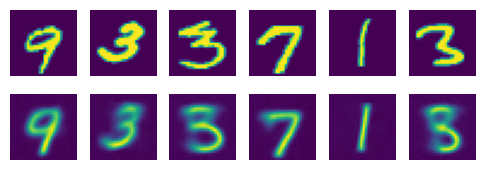

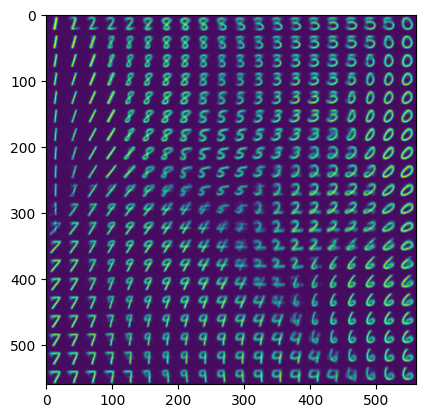

In [4]:
model = VAETrainer.load_model_checkpoint(model_name)
model.eval()

from plotting import plot_samples_with_reconstruction
from plotting import plot_latent_images
# plot some samples and their reconstructions

plot_samples_with_reconstruction(model, next(iter(test_loader)))
plot_latent_images(model)